# Hyperparameters

In [1]:
NUM_TREES_PER_CLASS = 5

# Preliminaries

In [2]:
%cd /Users/saketramdurbha/repos/cawl
%pwd

/Users/saketramdurbha/repos/cawl


'/Users/saketramdurbha/repos/cawl'

In [3]:
import random

import torch
import numpy as np
import pandas as pd


In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [5]:
from cawl.data.trajectory_regression_dataset import AISTrajectoryRegressionDataset
from cawl.data.gp_kernel_dataset import GPKernelShipClassificationDataset, extract_data
from cawl.models.gp.multioutput_rbf_linear_gp import load_or_train_models
from cawl.models.tree.per_class_decision_tree_model import PerClassDecisionTreeModel

from cawl.models.wl.wl import MLP, train, eval_model, eval_majority_vote

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Load data

In [7]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_01.pkl


Scaling trajectories for each MMSI: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3453/3453 [00:00<00:00, 4112.04it/s]


===== Dataset Statistics =====
Total number of AIS messages: 2128288
Number of unique MMSIs: 3453
Date range: 2024-01-01 00:00:00 to 2024-01-01 23:59:59


Number of vessel groups: 9


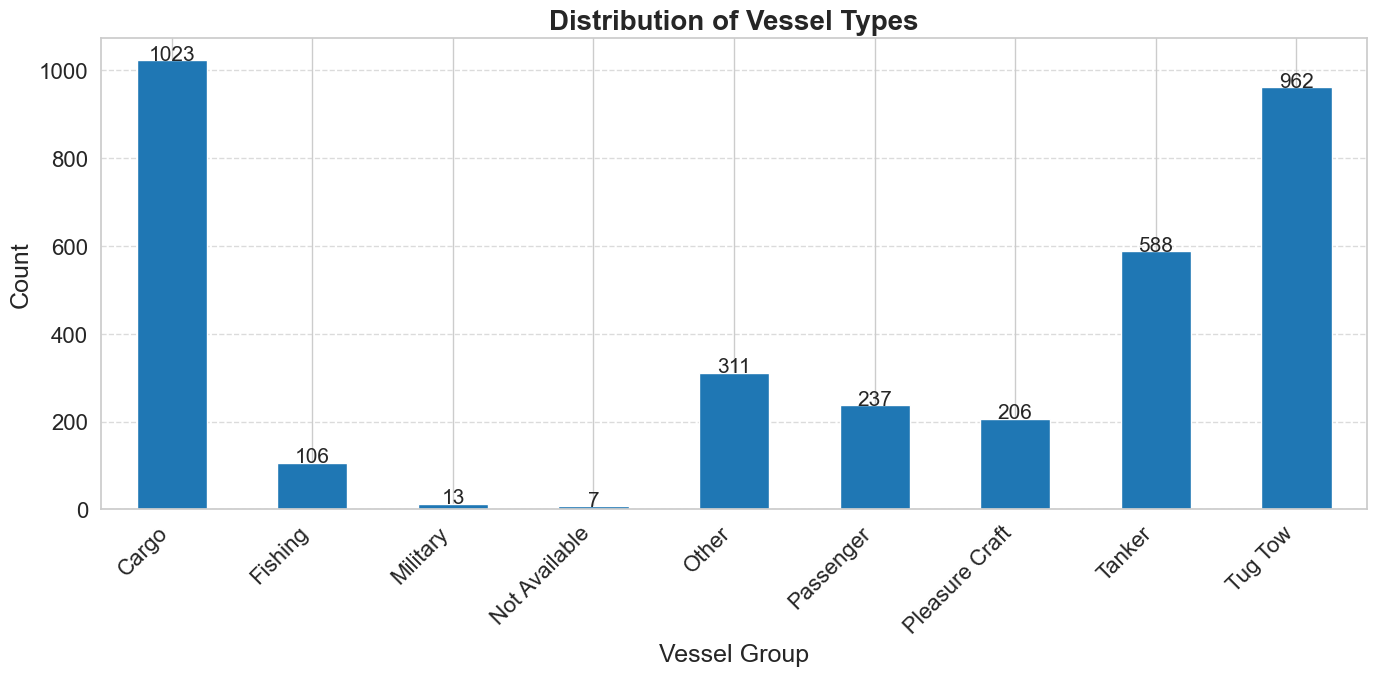

In [8]:
group_counts = gp_regression_dataset.plot_vessel_group_histogram(figsize=(14, 7))

In [9]:
reload_existing_models = True
models, likelihoods, losses = load_or_train_models(date_range, gp_regression_dataset, device, reload_existing_models)
print(f"Successfully loaded/trained {len(models)} models for {len(gp_regression_dataset)} trajectories")

Found existing model bundle for date range 2024-01-01 with 3453 trajectories
Loading models from models/rbf_and_linear_kernel_classification_bundle_2024-01-01_n3453.pt instead of retraining...


Loading models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3453/3453 [00:38<00:00, 89.65it/s]


Successfully loaded 3453 models
Successfully loaded/trained 3453 models for 3453 trajectories


In [10]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Parameter name: likelihood.raw_task_noises                 value = [-0.45829373598098755, -0.40521514415740967, -0.5071281790733337, -0.37111741304397583, -0.5067406296730042, -0.5076672434806824]
Parameter name: likelihood.raw_noise                       value = [-0.49265846610069275]
Parameter name: mean_module.base_means.0.raw_constant      value = 0.09970027953386307
Parameter name: mean_module.base_means.1.raw_constant      value = -0.08868623524904251
Parameter name: mean_module.base_means.2.raw_constant      value = 0.00029586770688183606
Parameter name: mean_module.base_means.3.raw_constant      value = 0.00010291425860486925
Parameter name: mean_module.base_means.4.raw_constant      value = 0.00023743335623294115
Parameter name: mean_module.base_means.5.raw_constant      value = -0.0020240405574440956
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.7152479887008667], [0.04727381467819214], [0.008950814604759216], [0.16344818472862244], [-0.0059141409583

In [11]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()
print(unique_group_ids)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [12]:
tree_train_dataset, train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.20, 0.40, 0.10, 0.30])
print(len(tree_train_dataset), len(train_dataset), len(validation_dataset), len(test_dataset))

691 1382 345 1035


In [13]:
X_tree_train, y_tree_train, mmsis_tree_train = extract_data(tree_train_dataset)
X_train, y_train, mmsis_train = extract_data(train_dataset)
X_validation, y_validation, mmsis_validation = extract_data(validation_dataset)
X_test, y_test, mmsis_test = extract_data(test_dataset)

# Train the small decision trees model

In [54]:
pcdt_model = PerClassDecisionTreeModel(tree_train_dataset, max_depth=3, n_trees_per_class=NUM_TREES_PER_CLASS, confidence_threshold=0.75)
pcdt_model.train_all_trees()

Dataset loaded: 691 samples, 56 features, 9 classes
Training 5 trees per class = 45 total trees
Confidence threshold: 0.75
Training 5 trees for each of 9 classes...
Training set size: 691
Feature fraction per tree: 0.5
Max tree depth: 3


Training trees per class: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 55.66it/s]

Successfully trained 45 trees (5 per class)


## Majority vote of small decision trees performance on test set

In [55]:
pcdt_model.evaluate_ensemble(X_test, y_test, method="majority")

{'accuracy': 0.4434673366834171,
 'coverage': np.float64(0.7690821256038647),
 'predictions': array([ 6,  0,  7, ...,  0, -1, -1], shape=(1035,)),
 'true_labels': array([6, 0, 8, ..., 0, 7, 4], shape=(1035,)),
 'method': 'majority',
 'n_abstained': np.int64(239),
 'n_predicted': np.int64(796)}

# Train the learning from weak labelers model

In [56]:
l_train = pcdt_model.predict_ensemble(X_train, method=None)
l_train.shape

(1382, 45)

In [64]:
tree_accuracies = pcdt_model.calculate_individual_tree_accuracies(X_validation, y_validation)
tree_errors = []
accs = []
for class_id in pcdt_model.classes:
    tree_errors.extend( [1 - tree_result["accuracy"] for tree_result in tree_accuracies[class_id]])
    accs.extend( [tree_result["accuracy"] for tree_result in tree_accuracies[class_id]])

tree_errors = torch.tensor(tree_errors)
min(accs)

np.float64(0.6612903225806451)

In [58]:
# eta: is the upper bound on the accuracy of each weak labeler
# In general, we assume that it is given. However, we can tune it with the validation set. e.g. eta_list = [0.01, 0.05, 0.1, 0.15, 0.2]

eta = torch.ones((45, 1)) * 0.25  # Example eta values

# eta = tree_errors.detach()

input_dim = X_train.shape[1]
num_classes = len(unique_group_ids)

model = MLP(input_dim, num_classes=num_classes, dropout=0.3)
model = model.to(device)

# optimizer = torch.optim.AdamW(
#     model.parameters(), lr=3e-4, weight_decay=1e-4,
# )
optimizer = torch.optim.AdamW(model.parameters())

In [59]:
# Train the model using the weak labels, and if validation set is provided, use it for early stopping
NUM_EPOCHS = 1_000
model, best_val_loss = train(model, torch.tensor(X_train), torch.tensor(l_train), eta, optimizer, NUM_EPOCHS, torch.tensor(X_validation), torch.tensor(y_validation))

# If the validation set is not provided, output the latest model
# model, _ = train(model, X_train, l_train, eta, configs)

Epoch 1/1000, Loss: 2.2636, Constraints Violation: 0.2262, Validation Accuracy: 30.4348, Validation Loss: 2.1650
Epoch 2/1000, Loss: 2.1400, Constraints Violation: 0.2211, Validation Accuracy: 34.7826, Validation Loss: 2.0977
Epoch 3/1000, Loss: 2.0611, Constraints Violation: 0.2173, Validation Accuracy: 34.2029, Validation Loss: 2.0823
Epoch 4/1000, Loss: 2.0091, Constraints Violation: 0.2149, Validation Accuracy: 34.7826, Validation Loss: 2.0965
Epoch 5/1000, Loss: 1.9852, Constraints Violation: 0.2125, Validation Accuracy: 34.7826, Validation Loss: 2.1215
Epoch 6/1000, Loss: 1.9588, Constraints Violation: 0.2128, Validation Accuracy: 34.2029, Validation Loss: 2.1489
Epoch 7/1000, Loss: 1.9362, Constraints Violation: 0.2131, Validation Accuracy: 33.0435, Validation Loss: 2.1738
Epoch 8/1000, Loss: 1.9160, Constraints Violation: 0.2133, Validation Accuracy: 33.3333, Validation Loss: 2.1938
Epoch 9/1000, Loss: 1.8996, Constraints Violation: 0.2133, Validation Accuracy: 33.3333, Validat

In [61]:
test_acc, test_loss = eval_model(model, torch.tensor(X_test), torch.tensor(y_test))
print(f'The accuracy of the model on the test set is: {test_acc:.4f}')
print(test_loss)

The accuracy of the model on the test set is: 36.2319
1.897889494895935
